# CS244 Assignment 2 - Group 8
- Kevin Rothi (leader)
- J.Y. Ku
- John Lanier

# Note:

The is a resubmission of assignment 2. In our first submission, we accidently included boilerplate code that turned the red LED off on our sensor. Our readings for Red throughout were noisy and generally limited to double digits. At the time, we didn't know this was wrong. Upon analysing template data from assignment 3, we realized our error. The only changes made to our code were removing the 1 (plus a second redundant) line that turned off the Red LED. The only changes made to this notebook were in the text analysis of our plots. The new, correct data was run through the python in this notebook in the same way that the original, incorrect data was. 

Thank you for your understanding. :)

### Github Repository:
https://github.com/JBLanier/cs244fall2017

If you don't want to read this jupyter notebook in broken, paginated PDF form, the html version is available [here.](https://jblanier.xyz/hw2.html)

### Sampling Procedure
 - When the board turns on, it makes a GET request to http://54.183.4.218/time (our aws ec2 node.js server) to calibrate the actual UNIX time. With this, every sample can be sent tagged with an exact time and date regardless on any poweroffs.
 - The [BigNumber](https://github.com/nickgammon/BigNumber) libary is used to hande full-size millisecond timestamps as a single number because multiple functions for 64bit integers are missing.
 - A max sample rate of 50hz is enforced, and fine grain control of the MAX30105 FIFO sample queue is implemented to ensure a stable and low latency (relative to measured time) rate of sampling
 - Batches of 50 samples are POSTed in json format each second to the server. The JSON string is incrementally built over time during each discrete sample reading.
 - To increase speed, the provided HTTPClient is not used to send samples.
 - POSTing samples is done manually with WifiClient in order to a) take advantage of using the "connection: keep-alive" header, and b) send multiple packets if need be, both of which the HTTPLClient does not provide.
 - Sending 50 samples each second was determined from a multitude of timing measurements with different batch sizes. A POST to our NorCal server may take 80ms to complete, so 3 samples may still be lost each second. This was most acceptable loss we could find after several hours of trials and expirements. 
 
 - Sample groups are stored on the server side in Mongo as an object like so:  

       { pwr: "6.4",
         samples: [{t:1508814335313,ir:243653,r:223432},
                   {t:1508814335333,ir:243646,r:223736},
                   ....
                   ]
        }
        
        (here pwr is powerlevel, t is time)
        
- There is a single object stored per powerlevel.
- When samples for an existing powerlevel are reported, the new samples are appended to its array.
 
- CSV's are generated through a GET request handler implmented in the node.js server. 
- For assignment 2, the latest 6000 (120 seconds * 50Hz) entries in each of the the four samples arrays are queried, zipped together (without timestamps), and packed into a csv as part as a GET request response. You can make this request too, get it at http://54.183.4.218/hw2csv 
  (It may be different data by the time you read this, the server will return the latest 2 minutes of data it has received for each setting).
  
- The csv used in this report is in our [assignment 2 folder in the git repo.](https://github.com/JBLanier/cs244fall2017/blob/master/assignment_2/team8_assignment2.csv)


Let's look at the data we got:

(IR1,RED1 is 0.4mA,  
 IR2,RED2 is 6.4mA,  
 IR3,RED3 is 25.4mA, and  
 IR4,RED4 is 50.0mA)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('team8_assignment2.csv')
data.head()

,IR1,RED1,IR2,RED2,IR3,RED3,IR4,RED4
0,1406,1813,34963,41210,155622,181187,149977,179350
1,1410,1805,34927,41158,155590,181094,151572,181015
2,1403,1802,34923,41156,155799,181260,172360,200685
3,1409,1807,34907,41155,155810,181254,174125,202173
4,1393,1811,34910,41153,155836,181259,175758,203557


In [12]:
data.describe()

,IR1,RED1,IR2,RED2,IR3,RED3,IR4,RED4
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1351.422167,1688.064500,34852.164000,41428.928500,160377.226500,181608.129667,222658.280167,253720.271500
std,23.843204,43.193105,712.520711,766.668263,7083.907128,6943.960544,13877.627020,10304.682501
min,1264.000000,1587.000000,33719.000000,39936.000000,149080.000000,168446.000000,149977.000000,179350.000000
25%,1340.000000,1661.000000,34285.000000,40824.000000,155958.250000,177012.000000,210122.500000,243257.000000
50%,1349.000000,1677.000000,34849.000000,41423.000000,159442.500000,181108.000000,224834.000000,260174.000000
75%,1358.000000,1707.000000,35084.000000,41914.000000,162021.250000,184552.250000,230273.750000,262143.000000
max,1479.000000,1894.000000,38122.000000,44288.000000,206228.000000,223084.000000,262143.000000,262143.000000


Mean IR and Red values increase as current increases.

Each 2-minute sampling interval was completed by resting my thumb about 6mm away from the sensor. ![image](https://jblanier.xyz/hw2_image.jpg)  

  
  
   
Regardless there were still variations over time and jumps in each reading as I made both slow and quick adjustments to my hand.

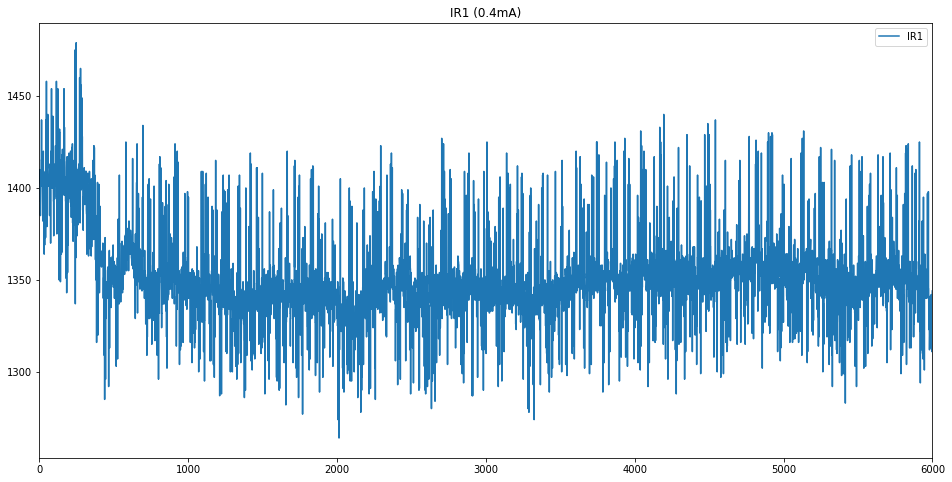

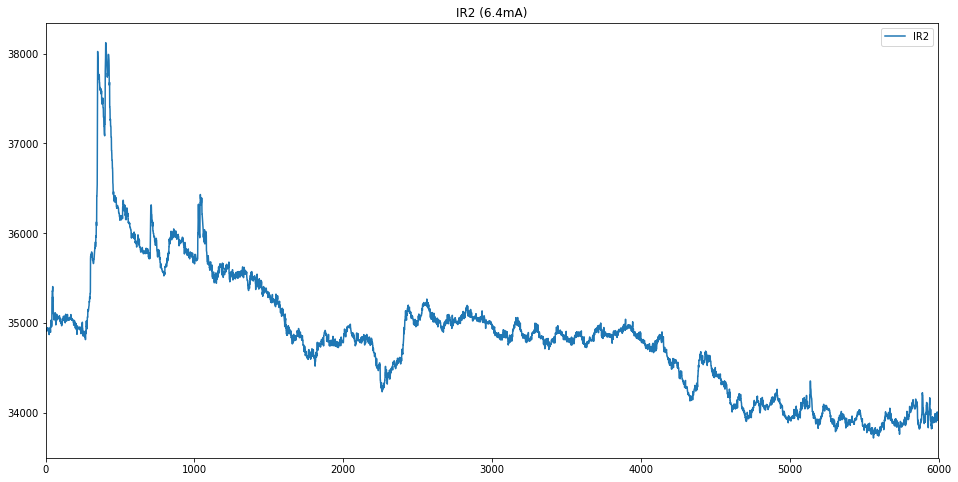

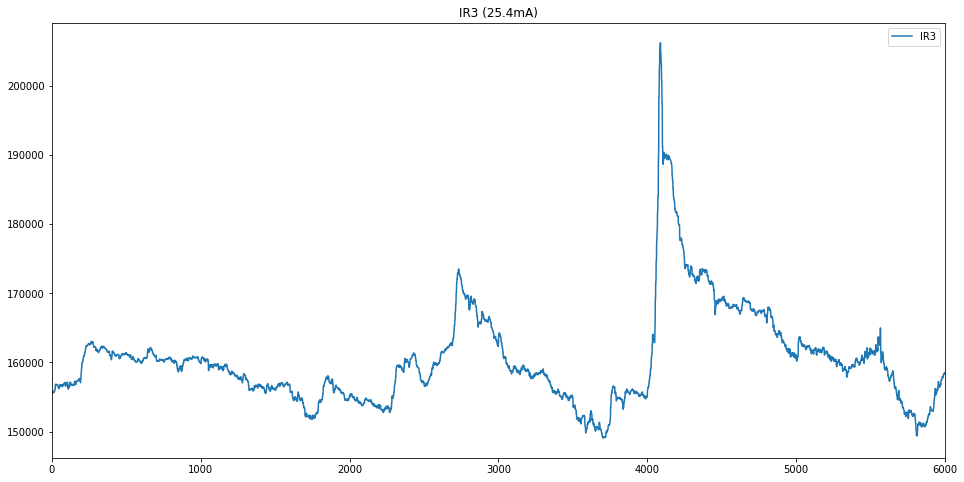

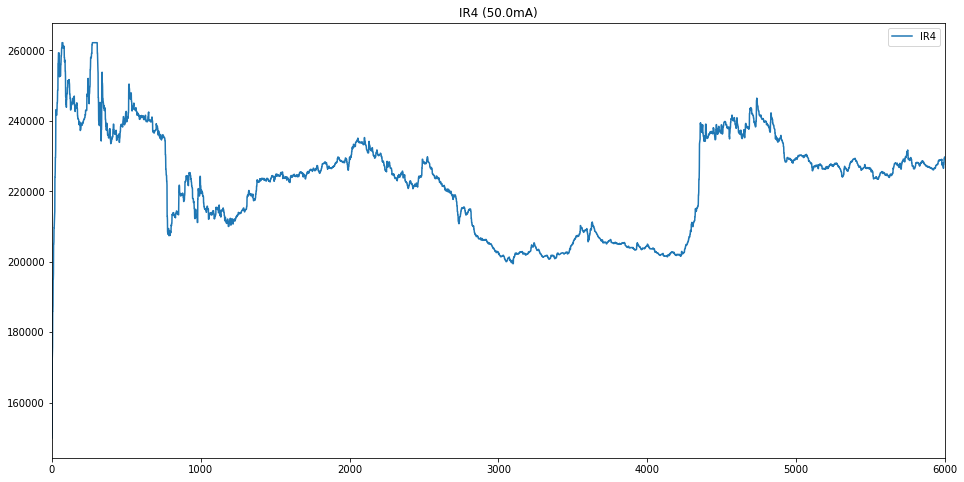

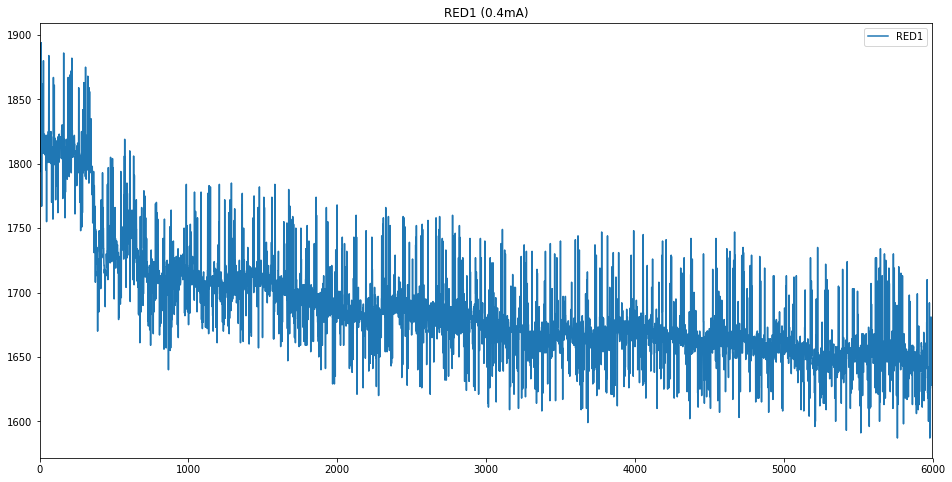

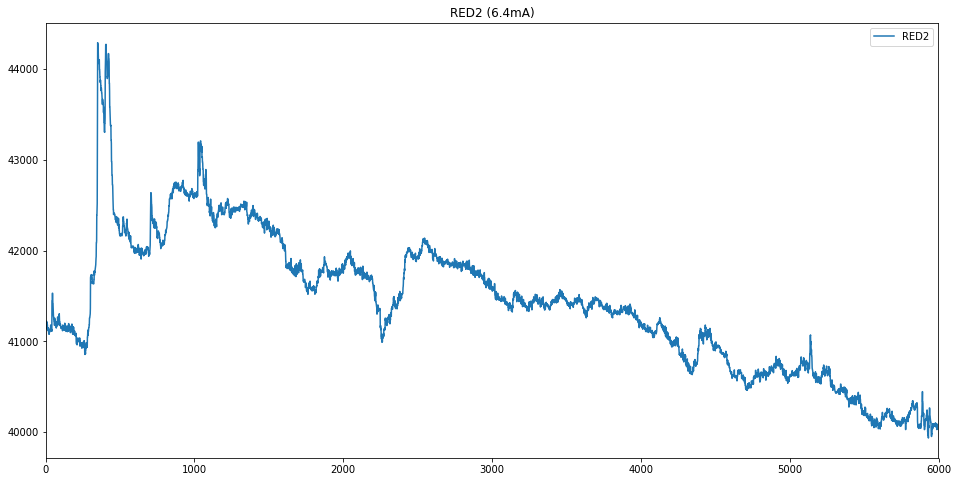

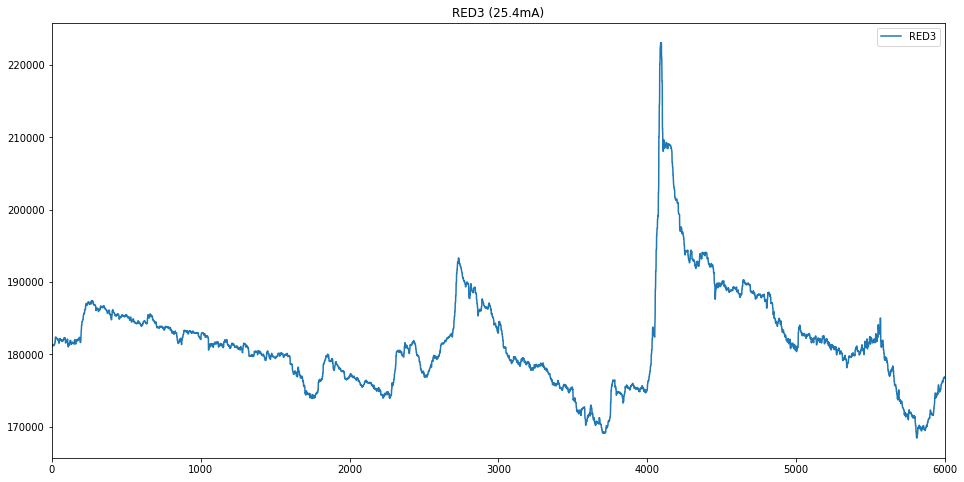

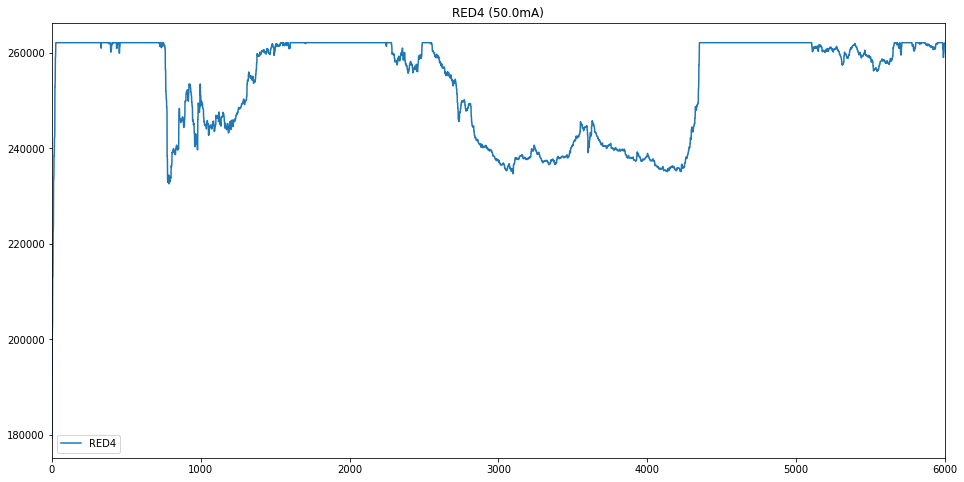

In [13]:
data.plot(y='IR1',title='IR1 (0.4mA)',figsize=(16,8))
data.plot(y='IR2',title='IR2 (6.4mA)',figsize=(16,8))
data.plot(y='IR3',title='IR3 (25.4mA)',figsize=(16,8))
data.plot(y='IR4',title='IR4 (50.0mA)',figsize=(16,8))
data.plot(y='RED1',title='RED1 (0.4mA)',figsize=(16,8))
data.plot(y='RED2',title='RED2 (6.4mA)',figsize=(16,8))
data.plot(y='RED3',title='RED3 (25.4mA)',figsize=(16,8))
data.plot(y='RED4',title='RED4 (50.0mA)',figsize=(16,8))
plt.show()

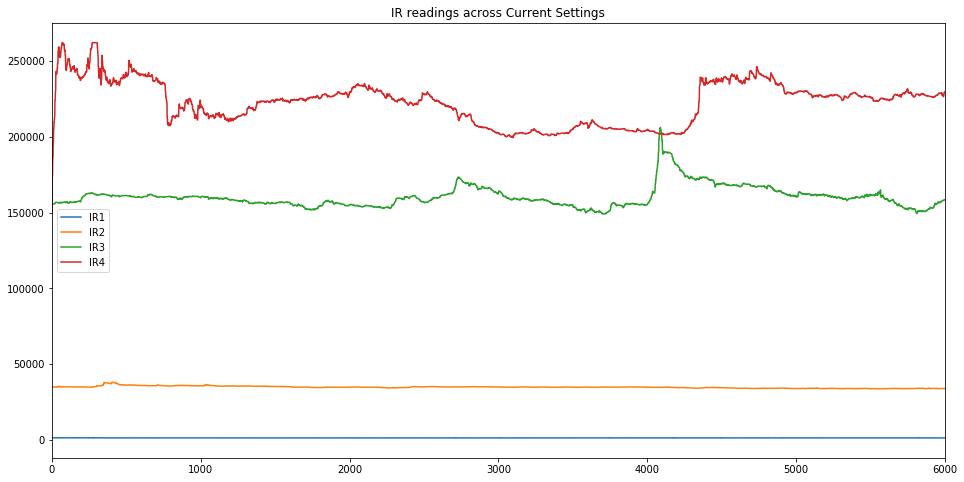

In [14]:
data.plot(y=['IR1','IR2','IR3','IR4'], title='IR readings across Current Settings',figsize=(16,8))
plt.show()

Above we can see that lower IR values come with lower variance. Also notice the clipping near the begginning of IR4 (red).

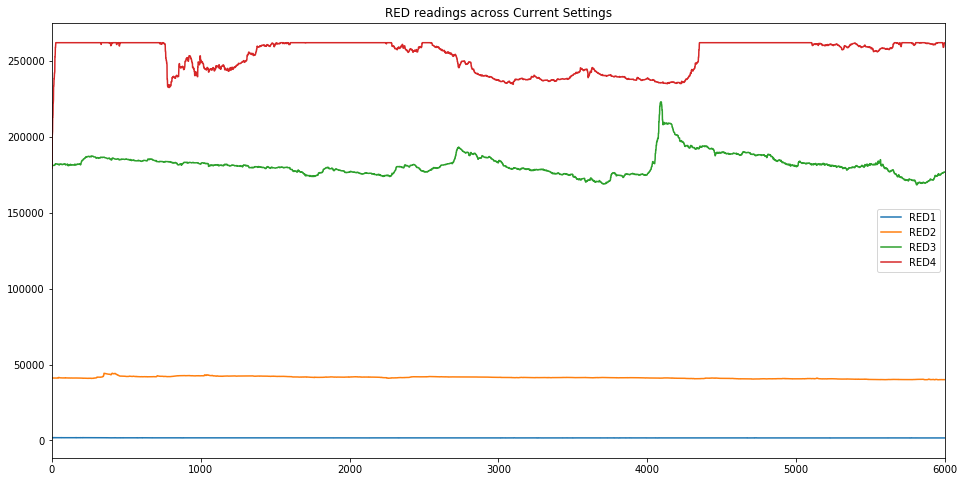

In [15]:
data.plot(y=['RED1','RED2','RED3','RED4'], title='RED readings across Current Settings',figsize=(16,8))
plt.show()

Here we see similar trends in RED. There was heavy clipping at the max powerlevel (IR4, red). 